# Sistem Rekomendasi Film Menggunakan Collaborative Filtering

## Project Overview
Sistem rekomendasi film bertujuan membantu pengguna menemukan film yang sesuai dengan preferensi mereka secara otomatis. Dengan banyaknya pilihan film, sistem ini dapat meningkatkan pengalaman pengguna dan membantu platform streaming meningkatkan engagement.

## Business Understanding
Permasalahan: Pengguna sering kesulitan memilih film yang sesuai dengan selera mereka di antara ribuan pilihan.
Solusi: Membangun sistem rekomendasi yang dapat memberikan saran film secara personal menggunakan pendekatan 

- **Collaborative Filtering**: Merekomendasikan film berdasarkan pola rating pengguna lain yang mirip.

## Data Understanding

Dataset MovieLens terdiri dari dua file utama:
- **movies.dat**: Informasi film (MovieID, Title, Genres)
- **ratings.dat**: Data rating yang diberikan user ke film (UserID, MovieID, Rating, Timestamp)

In [1]:
# install semua library yang dibutuhkan


import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# data understanding

movies = pd.read_csv(
    'datasets/movies.dat',
    sep='::',
    engine='python',
    names=['MovieID', 'Title', 'Genres'],
    encoding='latin1'
)
ratings = pd.read_csv(
    'datasets/ratings.dat',
    sep='::',
    engine='python',
    names=['UserID', 'MovieID', 'Rating', 'Timestamp'],
    encoding='latin1'
)

display(movies.head())
display(ratings.head())

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Exploratory Data Analysis (EDA)

Analisis awal untuk mengetahui jumlah user, film, rating, dan distribusi rating.

In [3]:
print("Jumlah film unik:", movies['MovieID'].nunique())
print("Jumlah user unik:", ratings['UserID'].nunique())
print("Jumlah rating:", ratings.shape[0])
print("\nDistribusi rating:")
print(ratings['Rating'].value_counts().sort_index())

Jumlah film unik: 3883
Jumlah user unik: 6040
Jumlah rating: 1000209

Distribusi rating:
Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: count, dtype: int64


## Data Preparation

Tahap ini bertujuan untuk membersihkan dan mempersiapkan data sebelum digunakan dalam pemodelan. Langkah-langkah yang dilakukan antara lain:
- Mengecek dan menangani missing value atau duplikasi data.
- Melakukan transformasi data jika diperlukan (misal: ekstraksi fitur genre, encoding, dsb.).
- Menyiapkan data agar siap digunakan untuk  collaborative filtering.

In [4]:
print("Missing value pada movies:\n", movies.isnull().sum())
print("Missing value pada ratings:\n", ratings.isnull().sum())
print("Duplikasi pada movies:", movies.duplicated().sum())
print("Duplikasi pada ratings:", ratings.duplicated().sum())

movies['MovieID'] = movies['MovieID'].astype(int)
ratings['UserID'] = ratings['UserID'].astype(int)
ratings['MovieID'] = ratings['MovieID'].astype(int)
ratings['Rating'] = ratings['Rating'].astype(int)

Missing value pada movies:
 MovieID    0
Title      0
Genres     0
dtype: int64
Missing value pada ratings:
 UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64
Duplikasi pada movies: 0
Duplikasi pada ratings: 0


### Content-Based Filtering dengan TF-IDF

Pada pendekatan ini, sistem merekomendasikan film berdasarkan kemiripan konten, yaitu genre film. Genre diubah menjadi representasi numerik menggunakan TF-IDF (Term Frequency-Inverse Document Frequency), lalu dihitung kemiripan antar film menggunakan cosine similarity. Rekomendasi diberikan berdasarkan film yang paling mirip dengan film yang dipilih pengguna.

In [5]:


# Membuat fitur genre sebagai string (tanpa tanda '|')
movies['Genres_str'] = movies['Genres'].apply(lambda x: x.replace('|', ' '))

# Inisialisasi dan fit TF-IDF Vectorizer pada genre
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['Genres_str'])

# Menghitung kemiripan antar film berdasarkan genre (TF-IDF)
cosine_sim_tfidf = cosine_similarity(tfidf_matrix)

# Fungsi rekomendasi film berdasarkan judul (TF-IDF)
def recommend_content_based_tfidf(title, top_n=5):
    idx = movies[movies['Title'].str.lower() == title.lower()].index
    if len(idx) == 0:
        print("Film tidak ditemukan.")
        return
    idx = idx[0]
    sim_scores = list(enumerate(cosine_sim_tfidf[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    film_idx = [i[0] for i in sim_scores]
    return movies.iloc[film_idx][['Title', 'Genres']]

# Contoh rekomendasi
judul_film = 'titanic (1997)'
print(f"Rekomendasi film mirip dengan '{judul_film}':")
display(recommend_content_based_tfidf(judul_film))

Rekomendasi film mirip dengan 'titanic (1997)':


,Title,Genres
24,Leaving Las Vegas (1995),Drama|Romance
34,Carrington (1995),Drama|Romance
45,How to Make an American Quilt (1995),Drama|Romance
48,When Night Is Falling (1995),Drama|Romance
57,"Postino, Il (The Postman) (1994)",Drama|Romance


## Membagi Data untuk Training dan Validasi untuk Collaborative Filtering

Data rating dibagi menjadi 80% data training dan 20% data validasi.

In [7]:
# data splitting
ratings_train, ratings_val = train_test_split(
    ratings, test_size=0.2, random_state=42, shuffle=True
)

print("Jumlah data train:", ratings_train.shape[0])
print("Jumlah data validasi:", ratings_val.shape[0])

Jumlah data train: 800167
Jumlah data validasi: 200042


## Training Model Collaborative Filtering (Neural Network)

Pada tahap ini, model rekomendasi dibangun menggunakan embedding untuk user dan movie. Skor kecocokan dihitung dengan dot product embedding, ditambah bias, dan diaktivasi dengan sigmoid agar output berada di rentang [0, 1]. Model di-train menggunakan data training dan divalidasi pada data validasi.

In [8]:

# Siapkan data untuk training
min_rating = ratings['Rating'].min()
max_rating = ratings['Rating'].max()

# x_train dan x_val: pasangan (UserID, MovieID)
x_train = ratings_train[['UserID', 'MovieID']].values
x_val = ratings_val[['UserID', 'MovieID']].values

# y_train dan y_val: rating dinormalisasi ke [0, 1]
y_train = ratings_train['Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y_val = ratings_val['Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

num_users = ratings['UserID'].max() + 1  # pastikan ID mulai dari 0
num_movies = ratings['MovieID'].max() + 1

class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.reduce_sum(user_vector * movie_vector, axis=1, keepdims=True)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)

embedding_size = 50
model = RecommenderNet(num_users, num_movies, embedding_size)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 172s 14ms/step - loss: 0.6312 - root_mean_squared_error: 0.2613 - val_loss: 0.5901 - val_root_mean_squared_error: 0.2221
Epoch 2/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 162s 13ms/step - loss: 0.5847 - root_mean_squared_error: 0.2152 - val_loss: 0.5850 - val_root_mean_squared_error: 0.2158
Epoch 3/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 185s 15ms/step - loss: 0.5750 - root_mean_squared_error: 0.2036 - val_loss: 0.5843 - val_root_mean_squared_error: 0.2130
Epoch 4/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 174s 14ms/step - loss: 0.5662 - root_mean_squared_error: 0.1927 - val_loss: 0.5867 - val_root_mean_squared_error: 0.2129
Epoch 5/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 184s 15ms/step - loss: 0.5603 - root_mean_squared_error: 0.1834 - val_loss: 0.5904 - val_root_mean_squared_error: 0.2141
Epoch 6/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 171s 14ms/step - loss: 0.5559 - root_mean_squared_error: 0.1763 - val_loss: 0.5943 - val_root_mean_squared_error: 0.2159
Epoch 7/10

##  Visualisasi hasil training

Grafik berikut menunjukkan perkembangan nilai Root Mean Squared Error (RMSE) pada data training dan validasi selama proses training model. Visualisasi ini membantu untuk memantau performa model, serta mendeteksi adanya overfitting atau underfitting pada proses pelatihan.

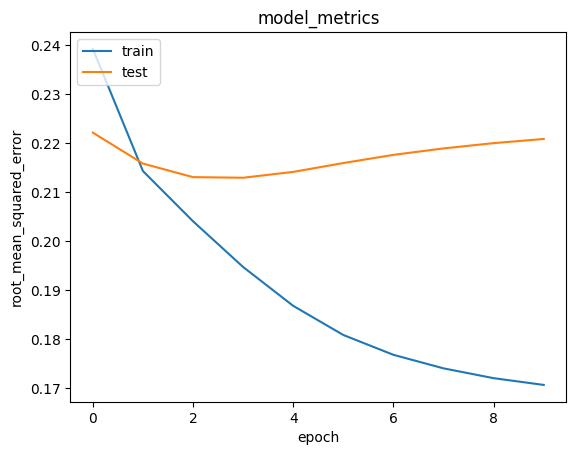

RMSE Training dan Validasi per Epoch:
Epoch  1: Training RMSE = 0.2392 | Validation RMSE = 0.2221
Epoch  2: Training RMSE = 0.2142 | Validation RMSE = 0.2158
Epoch  3: Training RMSE = 0.2040 | Validation RMSE = 0.2130
Epoch  4: Training RMSE = 0.1947 | Validation RMSE = 0.2129
Epoch  5: Training RMSE = 0.1867 | Validation RMSE = 0.2141
Epoch  6: Training RMSE = 0.1808 | Validation RMSE = 0.2159
Epoch  7: Training RMSE = 0.1768 | Validation RMSE = 0.2175
Epoch  8: Training RMSE = 0.1740 | Validation RMSE = 0.2189
Epoch  9: Training RMSE = 0.1720 | Validation RMSE = 0.2199
Epoch 10: Training RMSE = 0.1706 | Validation RMSE = 0.2208

RMSE Terbaik:
Training RMSE terbaik: 0.1706
Validation RMSE terbaik: 0.2129


In [9]:

# visualisasi loss
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualisasi hasil training dalam bentuk teks
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

print("RMSE Training dan Validasi per Epoch:")
print("="*40)
for epoch, (tr, val) in enumerate(zip(train_rmse, val_rmse), 1):
    print(f"Epoch {epoch:2d}: Training RMSE = {tr:.4f} | Validation RMSE = {val:.4f}")

print("\nRMSE Terbaik:")
print(f"Training RMSE terbaik: {min(train_rmse):.4f}")
print(f"Validation RMSE terbaik: {min(val_rmse):.4f}")

## Hasil Visualisasi Loss/RMSE

Berdasarkan hasil RMSE pada data training dan validasi di setiap epoch, terlihat bahwa nilai RMSE pada data validasi cukup stabil dan tidak terlalu jauh dari nilai RMSE pada data training.  
Hal ini menunjukkan bahwa model memiliki kemampuan generalisasi yang baik dan tidak mengalami overfitting secara signifikan.  
Dengan demikian, model yang dibangun sudah cukup optimal untuk memberikan rekomendasi film kepada pengguna berdasarkan data yang tersedia.

## Sistem Rekomendasi Film Berdasarkan Model

Pada tahap ini, model yang telah dilatih digunakan untuk memberikan rekomendasi film kepada user. Sistem akan memprediksi skor kecocokan antara user dan seluruh film yang belum pernah dirating, lalu menampilkan film dengan skor prediksi tertinggi.

In [10]:

def recommend_movies_for_user(user_id, model, movies, ratings, top_n=10):
    # Cari semua MovieID yang sudah dirating user
    movies_rated = ratings[ratings['UserID'] == user_id]['MovieID'].tolist()
    # Cari MovieID yang belum pernah dirating user
    movies_not_rated = movies[~movies['MovieID'].isin(movies_rated)]
    
    # Siapkan data prediksi: pasangan (user_id, movie_id)
    user_movie_array = np.array([[user_id, movie_id] for movie_id in movies_not_rated['MovieID']])
    
    # Prediksi skor dengan model
    ratings_pred = model.predict(user_movie_array, verbose=0).flatten()
    
    # Ambil indeks top_n skor tertinggi
    top_indices = ratings_pred.argsort()[-top_n:][::-1]
    recommended_movie_ids = movies_not_rated.iloc[top_indices]['MovieID'].values
    
    print(f"Rekomendasi untuk UserID: {user_id}")
    print("="*30)
    print("Film dengan rating tertinggi dari user:")
    print("-"*30)
    # Tampilkan 5 film dengan rating tertinggi yang pernah dirating user
    top_user_movies = (
        ratings[ratings['UserID'] == user_id]
        .sort_values(by='Rating', ascending=False)
        .head(5)
        .merge(movies, on='MovieID')
    )
    for row in top_user_movies.itertuples():
        print(f"{row.Title} : {row.Rating}")
    
    print("-"*30)
    print(f"Top {top_n} rekomendasi film:")
    print("-"*30)
    recommended_movies = movies[movies['MovieID'].isin(recommended_movie_ids)]
    for row in recommended_movies.itertuples():
        print(f"{row.Title} : {row.Genres}")

# penggunaan
recommend_movies_for_user(user_id=4, model=model, movies=movies, ratings=ratings, top_n=10)

Rekomendasi untuk UserID: 4
Film dengan rating tertinggi dari user:
------------------------------
Hustler, The (1961) : 5
Raiders of the Lost Ark (1981) : 5
Rocky (1976) : 5
Saving Private Ryan (1998) : 5
Star Wars: Episode IV - A New Hope (1977) : 5
------------------------------
Top 10 rekomendasi film:
------------------------------
Shawshank Redemption, The (1994) : Drama
Schindler's List (1993) : Drama|War
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) : Sci-Fi|War
Godfather, The (1972) : Action|Crime|Drama
Casablanca (1942) : Drama|Romance|War
Citizen Kane (1941) : Drama
Monty Python and the Holy Grail (1974) : Comedy
Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954) : Action|Drama
American Beauty (1999) : Comedy|Drama
Sanjuro (1962) : Action|Adventure
